# COVID Classification Challenge

In this challenge you will train a classifier to distinguish chest x-ray images of patients with no lung conditions, those with pneumonia, and those with COVID-19. Your network is expected to accept patches of images with shape (1,320,320) and predict a classification for each: 0 for normal, 1 for pneumonia, and 2 for COVID.

The training set in `training_data.zip` contains a few normal and pneumonia patients but is primarily COVID cases. Included is a pre-trained network which can distinguish between normal and pneumonia patients only, this can be used however you like to train your own classifier or not used at all, however it's training set of normal/pneumonia images is much larger than what you are provided.

The testing data in `test_data.zip` is a mix of all three categories with which your classifier will be assessed. The criteria for this challenge is overall accuracy of your predictions for this set, runtime performance, and consideration for implementation. 

This notebook has some starter code for loading the data and the pre-trained network, as well as the routine to run to generate your prediction on the test set.

In [1]:
!pip install monai
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import timeit
import datetime
import getpass

import monai
from monai.data import PILReader, Dataset, DataLoader
from monai.networks.nets import Classifier, DenseNet121
from monai.transforms import (
    LoadImage,
    Lambda,
    AddChannel,
    Resize,
    Compose,
    ToTensor,
)


     |████████████████████████████████| 584 kB 4.2 MB/s 


In [3]:
def get_label(filename):
            """Choose a label for the given image based on its file name."""
            if "normal_" in filename:
                return 0

            if "pneumonia_" in filename:
                return 1

            if "covid_" in filename:
                return 2

            return -1
            
image_files = sorted(glob.glob("/content/training_data/training_data/*.png"))
labels = list(map(get_label, image_files))
normal_count = labels.count(0)
pneumonia_count = labels.count(1)
covid_count = labels.count(2)

normal_count, pneumonia_count, covid_count

(150, 150, 949)

### Data Loading

There are too many covid images so in order to make it more balanced we are going to modify the `CovidImageDataset` class

In [8]:
crop_size = (320, 320)  # size of images expected by the pre-trained network

class CovidImageDataset(Dataset):
    """
    Construct a dataset of x-ray images, selecting the label based on file name. 
    If the file name isn't given a category (ie. test images), it's label will be -1.
    Feel free to change this class to speed things up but don't change it's behaviour.
    """

    def __init__(self, image_dir, transform):
        image_files = sorted(glob.glob(image_dir + "/*.png"))

        super().__init__(data=image_files, transform=transform)

        self.labels = list(map(get_label, image_files))

    def __getitem__(self, index):
        return super().__getitem__(index), self.labels[index]

class TrainCovidImageDataset(Dataset):

    def __init__(self, image_dir, transform):
        image_files = sorted(glob.glob(image_dir + "/*.png"))
        self.transform = transform

        self.normalImage_list = [nm for nm in image_files if "normal_" in nm]
        self.pneumoniaImage_list = [pn for pn in image_files if "pneumonia_" in pn]
        self.covidImage_list = [cv for cv in image_files if "covid_" in cv]
    
    # There are many more photos of covid than normal and pneumonia, 
    # so we modify it to return the same amount of every image.
    def __getitem__(self, index):
        if index % 3 == 0:
          return self.transform(self.normalImage_list[index % len(self.normalImage_list)]), 0
        if index % 3 == 1:
          return self.transform(self.pneumoniaImage_list[index % len(self.pneumoniaImage_list)]), 1
        if index % 3 == 2:
          return self.transform(self.covidImage_list[index % len(self.covidImage_list)]), 2
      
    def __len__(self):
        return 2847

train_transforms = Compose(
    [
        LoadImage(image_only=True, reader=PILReader()),  # Load each image
        Lambda(lambda im: im if im.ndim==2 else im[...,0]),  # many images are grayscale so select red channel
        AddChannel(),  # add a 1-size channel dimension
        Resize(crop_size, "area"),  # resize (crop or pad with 0) to the given size
        ToTensor(),
    ]
)


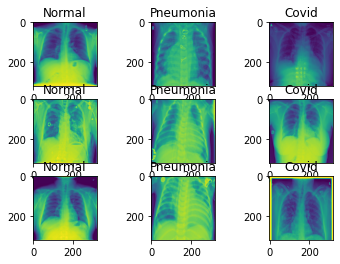

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def getName(label):
  if label == 0:
    return 'Normal'
  if label == 1:
    return 'Pneumonia'
  if label == 2:
    return 'Covid'
    
train_ds = TrainCovidImageDataset("/content/training_data/training_data", train_transforms)

fig =plt.figure()
cols = 3
rows = 3

for i in range(1, cols*rows+1):
  im, label = train_ds[i-1]
  fig.add_subplot(rows, cols, i)
  plt.title(getName(label))
  plt.imshow(im[0])

### Network

In the next cell we create an instance of `DenseNet`

In [16]:
net = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=3
)

In [17]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)
max_epochs = 10

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
import datetime

epoch_loss_values = []
net.to(device)

for epoch in range(max_epochs):
  print(f'epoch {epoch}/{max_epochs}')
  net.train()
  epoch_loss = 0
  step = 0

  for ndx, batch_data in enumerate(train_dl):
    step += 1
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    
    if ndx % 8 == 0:
      print(f"{step}/{len(train_ds) // train_dl.batch_size}, "
          f"train_loss: {loss.item():.4f}")
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, {datetime.datetime.now()}")

epoch 0/10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/88, train_loss: 1.0836
9/88, train_loss: 1.0321
17/88, train_loss: 0.9724
25/88, train_loss: 0.9995
33/88, train_loss: 0.9867
41/88, train_loss: 1.0204
49/88, train_loss: 0.9781
57/88, train_loss: 0.9800
65/88, train_loss: 0.8658
73/88, train_loss: 0.8445
81/88, train_loss: 0.8353
89/88, train_loss: 0.8054
epoch 1 average loss: 0.9279, 2021-09-09 13:59:08.752026
epoch 1/10
1/88, train_loss: 0.8171
9/88, train_loss: 0.8045
17/88, train_loss: 0.7759
25/88, train_loss: 0.6341
33/88, train_loss: 0.6112
41/88, train_loss: 0.7637
49/88, train_loss: 0.6389
57/88, train_loss: 0.6391
65/88, train_loss: 0.5585
73/88, train_loss: 0.5673
81/88, train_loss: 0.5561
89/88, train_loss: 0.5996
epoch 2 average loss: 0.6877, 2021-09-09 14:01:13.015102
epoch 2/10
1/88, train_loss: 0.5299
9/88, train_loss: 0.6973
17/88, train_loss: 0.5270
25/88, train_loss: 0.4696
33/88, train_loss: 0.4545
41/88, train_loss: 0.4462
49/88, train_loss: 0.5496
57/88, train_loss: 0.3718
65/88, train_loss: 0.4956
73/88, train

### Test Routine

This routine will apply the test images to the given network (or any other callable accepting batches of images and returning a label tensor) and save the predictions with total runtime value to an output file. This should run once your network is done training to generate the submission file you will hand in as your results. This will contain the predictions and the average runtime your network took to predict for a batch of 100. 

**Please don't modify any of the code in this routine!**

In [19]:
def predict(net, test_data_dir="/content/test_data/test_data", device=0, timeit_count=10, notebook_file="challenge.ipynb"):
    """
    Predict the classification for images in the test set using the calleable `net`. The test
    data is expected to be found in `test_data_dir`. Batches will be moved to device `device`.
    The prediction will be run `timeit_count` number of times over the dataset to get an 
    average runtime value.
    """
    def choose_channel(img):
        return img[...,0] if img.ndim==3 else img

    test_transforms = Compose(
        [
            LoadImage(image_only=True, reader=PILReader()),
            Lambda(lambda im: im if im.ndim==2 else im[...,0]),
            AddChannel(),
            Resize(crop_size, "area"),
            ToTensor(),
        ]
    )

    test_ds = CovidImageDataset(test_data_dir, test_transforms)
    test_loader = DataLoader(test_ds, batch_size=100, num_workers=10)

    predictions = []

    # apply the network to predict a label for each image
    with torch.no_grad():
        for batch, _ in test_loader:
            pred = net(batch.to(device))
            pred = pred.argmax(1)
            predictions.append(pred)

    # do prediction again on a single batch using timeit to get an average network runtime
    test_batch, _ = monai.utils.first(test_loader)
    test_batch = test_batch.to(device)

    with torch.no_grad():
        time = timeit.timeit(lambda: net(test_batch), number=timeit_count)

    predictions = torch.cat(predictions)
    time /= timeit_count

    pred_filename_pattern = f"predictions_{getpass.getuser()}_%Y%m%d%H%M%S.npz"
    pred_filename = datetime.datetime.now().strftime(pred_filename_pattern)
    
    try:
        with open(notebook_file) as o:
            notebook = o.read()
    except IOError:
        notebook = "Not found"

    np.savez_compressed(pred_filename, predictions=predictions.cpu().numpy(), time=time, notebook=notebook)

    return pred_filename, time, predictions

pred_filename, time, preds = predict(net.to(0).eval())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
# We get the correct results from the .txt 
arr = []
results = []
with open("test_ground_truth.txt",'r') as f:
  arr = f.readlines()

for num in arr:
  num = int(num[0])
  results.append(num)


In [23]:
correct_covid = 0
total_covid = 0
correct_pneumonia = 0
total_pneumonia = 0
correct_normal = 0
total_normal = 0

# 0 normal, 1 pneumonia, 2 covid

for ndx, num in enumerate(preds):
  if ndx >= 705:
    break
  if results[ndx] == 0:
    total_normal += 1
    if num == results[ndx]:
      correct_normal += 1
  if results[ndx] == 1:
    total_pneumonia += 1
    if num == results[ndx]:
      correct_pneumonia += 1
  if results[ndx] == 2:
    total_covid += 1
    if num == results[ndx]:
      correct_covid += 1

total_correct = correct_normal + correct_pneumonia + correct_covid
total = total_normal + total_pneumonia + total_covid
  

print(f"Correct normal: {correct_normal}/{total_normal}, {correct_normal/total_normal}")
print(f"Correct pneumonia: {correct_pneumonia}/{total_pneumonia}, {correct_pneumonia/total_pneumonia}")
print(f"Correct covid: {correct_covid}/{total_covid}, {correct_covid/total_covid}")
print(f"Total: {total_correct}/{total}, {total_correct/total}")


Correct normal: 159/235, 0.676595744680851
Correct pneumonia: 216/235, 0.9191489361702128
Correct covid: 232/235, 0.9872340425531915
Total: 607/705, 0.8609929078014185
